In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
np.random.seed(42) 
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

In [2]:
num_classes = len(os.listdir('/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/train'))

In [3]:
# Custom Dataset Class


class LiverDiseaseDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, _, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label_idx = class_names.index(label)  # Convert label to index
        return image, label_idx

# Get Class Names from Train Directory
class_names = os.listdir('/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/train')


In [4]:
train_dir = '/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/train'
training_data = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir,label)
    for patient in os.listdir(label_dir):
        patient_dir = os.path.join(label_dir, patient)
        images_dir = os.path.join(patient_dir, 'images')

        for filename in os.listdir(images_dir):
            image_path = os.path.join(images_dir, filename)
            training_data.append([image_path, patient, label])

In [5]:
test_dir = '/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/test'
testing_data = []

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir,label)
    for patient in os.listdir(label_dir):
        patient_dir = os.path.join(label_dir, patient)
        images_dir = os.path.join(patient_dir, 'images')

        for filename in os.listdir(images_dir):
            image_path = os.path.join(images_dir, filename)
            testing_data.append([image_path, patient, label])



In [6]:
valid_dir = '/kaggle/input/liver-diseases-dataset/Liver Disease Dataset/test'
validation_data = []

for label in os.listdir(valid_dir):
    label_dir = os.path.join(test_dir,label)
    for patient in os.listdir(label_dir):
        patient_dir = os.path.join(label_dir, patient)
        valid_dir = os.path.join(patient_dir, 'images')

        for filename in os.listdir(images_dir):
            image_path = os.path.join(images_dir, filename)
            validation_data.append([image_path, patient, label])

In [ ]:
image_path = training_data[0][0]
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.show()

In [8]:
import torchvision.transforms as transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.RandomRotation(degrees=5),  # Rotate image by ±5 degrees
        transforms.RandomHorizontalFlip(),  # Random horizontal flip
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}


In [9]:
train_dataset = LiverDiseaseDataset(training_data, transform=data_transforms['train'])
val_dataset = LiverDiseaseDataset(validation_data, transform=data_transforms['val'])
test_dataset = LiverDiseaseDataset(testing_data, transform=data_transforms['test'])

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights


class MSCA(nn.Module):
    def __init__(self, in_channels):
        super(MSCA, self).__init__()
        self.conv5x5 = nn.Conv2d(in_channels, in_channels, kernel_size=5, padding=2, groups=in_channels)
        self.conv7x1 = nn.Conv2d(in_channels, in_channels, kernel_size=(7, 1), padding=(3, 0), groups=in_channels)
        self.conv1x7 = nn.Conv2d(in_channels, in_channels, kernel_size=(1, 7), padding=(0, 3), groups=in_channels)
        self.conv5x1 = nn.Conv2d(in_channels, in_channels, kernel_size=(5, 1), padding=(2, 0), groups=in_channels)
        self.conv1x5 = nn.Conv2d(in_channels, in_channels, kernel_size=(1, 5), padding=(0, 2), groups=in_channels)
        self.conv3x1 = nn.Conv2d(in_channels, in_channels, kernel_size=(3, 1), padding=(1, 0), groups=in_channels)
        self.conv1x3 = nn.Conv2d(in_channels, in_channels, kernel_size=(1, 3), padding=(0, 1), groups=in_channels)
        self.channel_mixing = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        conv5x5 = self.conv5x5(x)
        conv1x7 = self.conv1x7(conv5x5)
        conv7x1 = self.conv7x1(conv1x7)
        conv1x3 = self.conv1x3(conv5x5)
        conv3x1 = self.conv3x1(conv1x3)
        conv1x5 = self.conv1x5(conv5x5)
        conv5x1 = self.conv5x1(conv1x5)
        multi_scale = conv5x5 + conv7x1 + conv5x1 + conv3x1
        mixed = self.channel_mixing(multi_scale)
        return mixed * x

In [15]:
class MSCANStage(nn.Module):
    def __init__(self, in_channels):
        super(MSCANStage, self).__init__()
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.attention = MSCA(in_channels)
        self.norm2 = nn.BatchNorm2d(in_channels)
        self.ffn = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=1)
        )
    
    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x

In [16]:
class MSCAN_ResNet50(nn.Module):
    def __init__(self, num_classes=3):  # ✅ num_classes is an integer (default=3)
        super(MSCAN_ResNet50, self).__init__()
        # Load pre-trained ResNet50
        weights = ResNet50_Weights.DEFAULT
        self.resnet = resnet50(weights=weights)
        
        # Remove original classifier and avgpool
        self.resnet.avgpool = nn.Identity()
        self.resnet.fc = nn.Identity()
        
        # Add MSCA attention block before final pooling
        self.mscan = MSCANStage(in_channels=2048)
        
        # Add adaptive pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(2048, num_classes)  # ✅ num_classes must be int
        
        # All parameters trainable
        for param in self.resnet.parameters():
            param.requires_grad = True

    def forward(self, x):
        # Forward through ResNet (without final pooling)
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)  # Shape: [B, 2048, H/32, W/32]
        
        # Apply MSCA attention
        x = self.mscan(x)
        
        # Final pooling and classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MSCAN_ResNet50(num_classes=3)  # ✅ Replace `3` with your actual number of classes
model = model.to(device)

# Example: Print the model architecture
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

MSCAN_ResNet50(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1 | train Loss: 0.8634, Acc: 0.5988
Epoch 1 | val Loss: 5.5214, Acc: 0.3264
Epoch 2 | train Loss: 0.8002, Acc: 0.6174
Epoch 2 | val Loss: 25.5324, Acc: 0.3074
Epoch 3 | train Loss: 0.7007, Acc: 0.6661
Epoch 3 | val Loss: 1.7224, Acc: 0.4972
Epoch 4 | train Loss: 0.5524, Acc: 0.7558
Epoch 4 | val Loss: 2.7772, Acc: 0.4231
Epoch 5 | train Loss: 0.3870, Acc: 0.8440
Epoch 5 | val Loss: 14.1834, Acc: 0.4213
Epoch 6 | train Loss: 0.2174, Acc: 0.9207
Epoch 6 | val Loss: 5.1272, Acc: 0.4972
Epoch 7 | train Loss: 0.1330, Acc: 0.9543
Epoch 7 | val Loss: 10.0446, Acc: 0.4896
Epoch 8 | train Loss: 0.1059, Acc: 0.9616
Epoch 8 | val Loss: 5.3410, Acc: 0.4972
Epoch 9 | train Loss: 0.0702, Acc: 0.9761
Epoch 9 | val Loss: 24.3781, Acc: 0.4896
Epoch 10 | train Loss: 0.0679, Acc: 0.9778
Epoch 10 | val Loss: 8.2012, Acc: 0.4706
Epoch 11 | train Loss: 0.0435, Acc: 0.9859
Epoch 11 | val Loss: 6.4861, Acc: 0.4782
Epoch 12 | train Loss: 0.0375, Acc: 0.9882
Epoch 12 | val Loss: 18.2371, Acc: 0.4896
Epoch

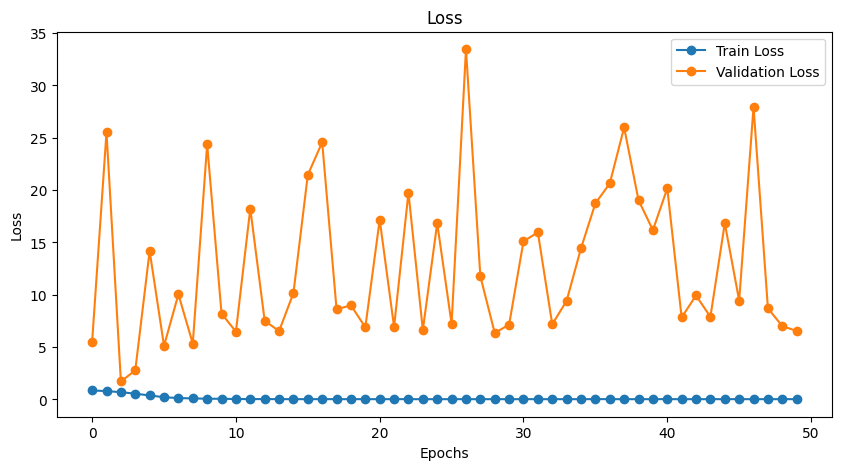

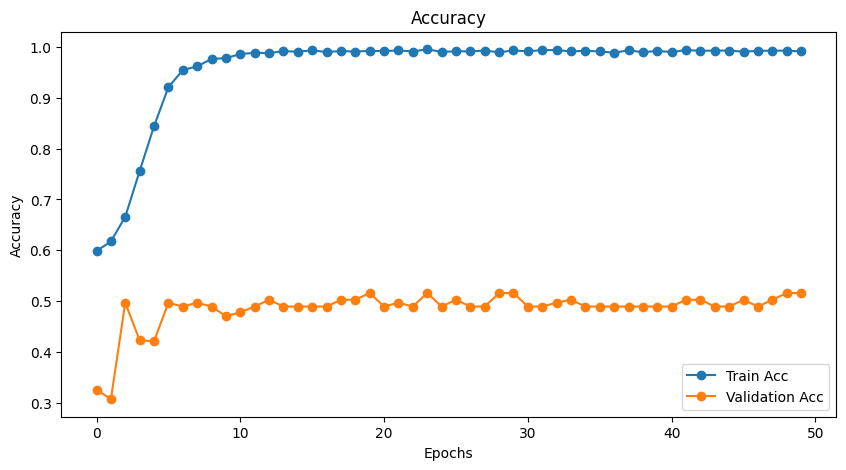

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

# Define the scheduler (reduce LR by factor of 0.1 every 5 epochs)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 50
train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = val_loader

        running_loss, correct = 0.0, 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = correct / len(dataloader.dataset)

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_acc.append(epoch_acc)
            scheduler.step()  # Update learning rate after each epoch
        else:
            val_losses.append(epoch_loss)
            val_acc.append(epoch_acc)

        print(f'Epoch {epoch+1} | {phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Loss'), plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Acc', marker='o')
plt.plot(val_acc, label='Validation Acc', marker='o')
plt.xlabel('Epochs'), plt.ylabel('Accuracy'), plt.title('Accuracy'), plt.legend()
plt.show()


In [22]:
torch.save(resnet50.state_dict(), "resnet50_model.pth")
print("Model saved successfully!")


AttributeError: 'function' object has no attribute 'state_dict'


Overall Metrics:
Accuracy: 55.72%
Precision: 0.6238
Sensitivity (Recall): 0.5572
F1 Score: 0.5807
Specificity: 0.8063

Classification Report:
              precision    recall  f1-score   support

           2     0.1827    0.2707    0.2182       133
           3     0.6029    0.6796    0.6390       181
           1     0.8023    0.6029    0.6884       350

    accuracy                         0.5572       664
   macro avg     0.5293    0.5177    0.5152       664
weighted avg     0.6238    0.5572    0.5807       664


Specificity per Class:
2: 0.6968
3: 0.8323
1: 0.8344


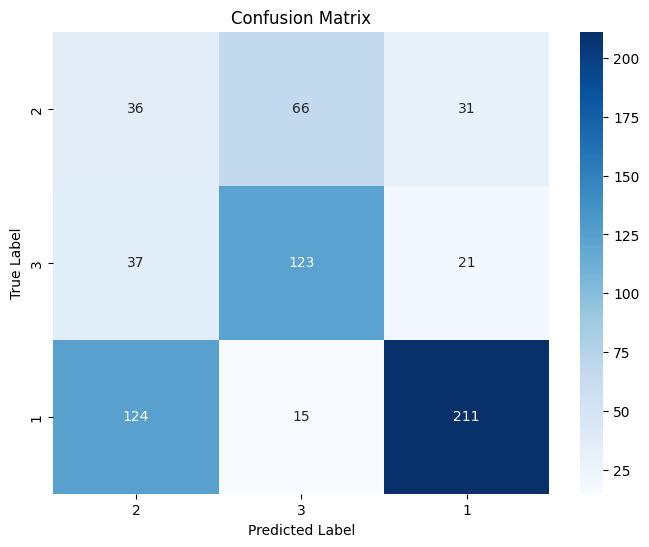

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Ensure model is in evaluation mode
model.eval()

# Store true and predicted labels
y_true = []
y_pred = []

# Run model on test data
with torch.no_grad():
    for inputs, labels in test_loader:  # Ensure test_loader is defined
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  
        _, preds = torch.max(outputs, 1)  # Get class with highest probability

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute overall metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')  # Sensitivity
f1 = f1_score(y_true, y_pred, average='weighted')

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Compute specificity per class
specificity_per_class = []
class_support = cm.sum(axis=1)  # Total samples per class
for i in range(len(class_names)):
    tn = np.sum(cm) - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])  # True Negatives
    fp = cm[:, i].sum() - cm[i, i]  # False Positives
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Avoid division by zero
    specificity_per_class.append(specificity)

# Compute overall specificity (weighted average)
overall_specificity = np.sum(np.array(specificity_per_class) * class_support) / np.sum(class_support)

# Print overall metrics
print("\nOverall Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {overall_specificity:.4f}")  # Overall Specificity

# Print class-wise metrics
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Print specificity per class
print("\nSpecificity per Class:")
for class_name, spec in zip(class_names, specificity_per_class):
    print(f"{class_name}: {spec:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
